# Probabilistic Methods (Discrete)

#### Anomaly Detection: Identification of items, events or observations which is significantly different from the remaining data.

* Non-parametric approach
* Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - less frequent - more likely to be an anomaly
    - Calculate probability
* Conditional probability

                                        Examples:

How many times we see an ip address in the dataset (count)
What is probability of ip address showing up in the dataset (ip count / total observations)
Conditional probability. Given an ip address, what is prob of a particular status(e.g authentication failure)

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline
import env

Use basic probability to identify anomalous requests. Using the methods covered in [this lesson](https://ds.codeup.com/anomaly-detection/discrete-probabilistic-methods/), examine the rest of the features in the api access logs data set.

Key points from the lesson
* When you have a variable that is not too noisy, you can have a baseline probability, then as new datapoints come in you can identify and compare the actual rate with the expected rate (probability).

- To detect anomalies in discrete variables we can look at two ways of summarizing the variable:

    - count: the number of times each unique value appears in the dataset
    - frequencies: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations
        - Both of the above can be found with the .value_counts method.
        
I'll start by duplicating and procedurally re-iterating much of what was done in the lesson/textbook. 

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# synthetic records, appended to the existing data frame
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [5]:
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [8]:
# Check counts of ip addresses
df.ip.value_counts().head(7)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
Name: ip, dtype: int64

In [9]:
# check frequencies of ip addresses 
df.ip.value_counts(normalize=True).head(7)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
35.175.171.137    0.000143
Name: ip, dtype: float64

In [7]:
# A UDF that combines both approaches and informational elements 
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [11]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head(7)

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502
24.26.242.9,21,0.001502
35.175.171.137,2,0.000143


<AxesSubplot:>

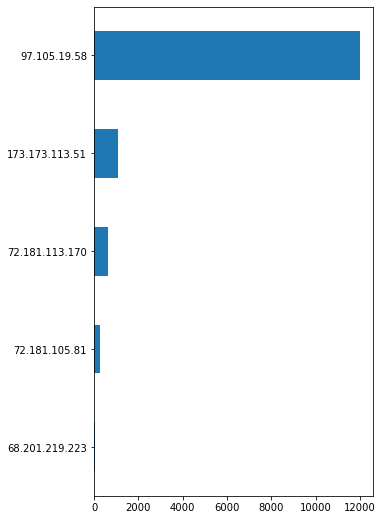

In [12]:
# from here discern how many unique ip addresses there are:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
# We shall see here that the vast majority of the requests come from a single ip address.

#### Conditional Probabilities: Probabilities using 2 discrete variables
When looking for an unexpected status, such as authentication failure, from a known/common IP address:

In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head(7)

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0
5,34.229.70.250,200,1.0
6,35.174.209.2,200,1.0


When the probability of a status when given the ip is 100%, it becomes apparent that was the only status code encountered by the ip address. To detect anomalies here we could look for two things:
* cases where the probability is less than 100%--meaning that multiple different status codes were encountered from the given ip address
* Status codes other than 200. 200 is easily the most common response code. Let's start with the latter. 

In [15]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


Interestingly enough, two ip addressed have exclusively encountered the 301 response, which is 
"The HyperText Transfer Protocol (HTTP) 301 Moved Permanently redirect status response code indicates that the requested resource has been definitively moved to the URL given by the Location headers. A browser redirects to the new URL and search engines update their links to the resource." 
Let's dig deeper.

In [16]:
df[df.ip == '95.31.16.121']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [17]:
df[df.ip == '97.105.15.120']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [18]:
# both were single instances, rather than repeated. 
# now for the former approach, less than 100% probability for a status code
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


Here we have uncovered a couple of 499 statuses from ip addresses which otherwise seem to process normal requests.
***
*** 
now to step away and explore on my own. 

In [5]:
df.columns

Index(['ip', 'request_method', 'request_path', 'http_version', 'status_code',
       'size', 'user_agent', 'size_mb'],
      dtype='object')

In [8]:
reqmet_df = value_counts_and_frequencies(df.request_method)
reqmet_df.head(7)

,count,proba
GET,13978,1.0


In [10]:
reqpat_df = value_counts_and_frequencies(df.request_path)
reqpat_df.head(50)
# I will return to this one and parse it further so it separates at each forward slash. 

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590
...,...,...
/api/v1/sales?page=34,67,0.004793
/api/v1/sales?page=42,67,0.004793
/api/v1/sales?page=37,67,0.004793
/api/v1/sales?page=43,67,0.004793


In [11]:
http_df = value_counts_and_frequencies(df.http_version)
http_df.head(10)

,count,proba
HTTP/1.1,13978,1.0


In [13]:
status_df = value_counts_and_frequencies(df.status_code)
status_df.head(10)
# perhaps worth further investigation, although in some essence it has already been tackled
# however, after I parse the request path I should be able to detect at what point it breaks.

,count,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


In [15]:
# I don't think size will help right now, so lastly I will check user_agent
useragent_df = value_counts_and_frequencies(df.user_agent)
useragent_df.head(10)

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072


To further explore this issue, handling the user_agent, status_code, a more parsed request_path may very well reveal new insights. I will start by further parsing the path. Going into this, it is worth remembering that there were 18 instances where the status code was anything other than 200. 

In [41]:
paths = pd.DataFrame(df.request_path.str.split('/', expand=True))

In [42]:
paths = paths.rename(columns={1: 'path_1', 2: 'path_2', 3: 'path_3', 4: 'path_4', 5: 'path_5', 6: 'path_6'})
paths = paths.drop([0], axis=1)

In [43]:
paths['path_1'].value_counts()
# perhaps an error is popping up in cases where the initial path is registered as blank space.

api              13745
                   107
documentation      100
favicon.ico         26
Name: path_1, dtype: int64

In [44]:
paths['path_2'].value_counts()
# additionally, an error may occur when the version is captitalized i.e. V1
# moreover, when items is right next to v1 rather than set apart by /

v1         13742
v1items        2
V1             1
Name: path_2, dtype: int64

In [45]:
paths['path_3'].value_counts()
# it becomes evident that page numbers in excess exist, another potential (likely) problem

sales?page=2       709
items              477
items?page=2       291
items?page=3       219
stores             162
                  ... 
items?page=0         1
stores?page=999      1
stores?page=666      1
HiZach!              1
items?page=4         1
Name: path_3, Length: 206, dtype: int64

In [46]:
paths['path_4'].value_counts()
# the majority are NaN at this point, but there is a blankspace instance four times

api          19
next_page     5
              4
?page=2       3
Name: path_4, dtype: int64

In [47]:
paths['path_5'].value_counts()
# all are NaN except for 19 instances where v1 is reiterated

v1    19
Name: path_5, dtype: int64

In [48]:
paths['path_6'].value_counts()
# these remaining 19 are likely all aligned with those that have occured on path 5
# if not, that is a problem. 

items?page=2    16
items            2
items?page=3     1
Name: path_6, dtype: int64

In [49]:
# Now I'll add these paths to the original dataframe
original_dataframe = df.copy()

In [50]:
df = pd.concat([df, paths], axis=1) 

In [51]:
df.columns

Index([            'ip', 'request_method',   'request_path',   'http_version',
          'status_code',           'size',     'user_agent',        'size_mb',
               'path_1',         'path_2',         'path_3',         'path_4',
               'path_5',         'path_6',                7],
      dtype='object')

In [54]:
# I missed '7'
paths[[7]].value_counts()

7        
next_page    1
dtype: int64

In [55]:
# This will seem a little redundant, but I'll check again using my UDF
path1_df = value_counts_and_frequencies(df.path_1)
path1_df.head(10)

,count,proba
api,13745,0.983331
,107,0.007655
documentation,100,0.007154
favicon.ico,26,0.001860


In [69]:
df.status_code.dtype

dtype('O')

In [67]:
favicon = df[df.path_1 == 'favicon.ico']
favicon[favicon.status_code != '200']
# so there are no instances where favicon is responsible for the error

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,path_1,path_2,path_3,path_4,path_5,path_6,7
timestamp,,,,,,,,,,,,,,,


In [72]:
documentation = df[df.path_1 == 'documentation']
documentation[documentation.status_code != '200']
# the same goes for documentation

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,path_1,path_2,path_3,path_4,path_5,path_6,7
timestamp,,,,,,,,,,,,,,,


In [75]:
#blank = df[df.path_1 == '']
blank[blank.status_code != '200']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,path_1,path_2,path_3,path_4,path_5,path_6,7
timestamp,,,,,,,,,,,,,,,


In [79]:
api = df[df.path_1 == 'api']
offender = api[api.status_code != '200']
# lesson learned, start with the most frequent. 

In [83]:
offender.shape
# all 18 erroneous status codes accounted for. 

(18, 15)

In [56]:
path2_df = value_counts_and_frequencies(df.path_2)
path2_df.head(10)

,count,proba
v1,13742,0.983116
NaN,233,0.016669
v1items,2,0.000143
V1,1,0.000072


In [87]:
v1 = offender[offender.path_2 == 'v1']
offender2 = v1[v1.status_code != '200']

In [88]:
offender2.shape
# still have all of them

(18, 15)

In [57]:
path3_df = value_counts_and_frequencies(df.path_3)
path3_df.head(10)

,count,proba
sales?page=2,709,0.050723
items,477,0.034125
items?page=2,291,0.020818
NaN,236,0.016884
items?page=3,219,0.015667
stores,162,0.011590
sales,155,0.011089
sales?page=3,91,0.006510
items?page=1,88,0.006296
sales?page=5,83,0.005938


In [92]:
salespage2 = offender2[offender2.path_3 == 'sales?page=2']
off3_1 = salespage2[salespage2.status_code != '200']
# this found 3 errors

In [94]:
items1 = offender2[offender2.path_3 == 'items']
off3_2 = items1[items1.status_code != '200']
# this spotted 4 errors. 11 remain. 
# ultimately the fastest way to do this would be to just read the entire pathname among the target group

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,path_1,path_2,path_3,path_4,path_5,path_6,7
timestamp,,,,,,,,,,,,,,,
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,api,v1,items,None,None,None,None
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,api,v1,items,None,None,None,None
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,api,v1,items,None,None,None,None
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,api,v1,items,None,None,None,None


In [96]:
target = df[df.status_code != '200']

In [98]:
failed_paths = target.request_path.value_counts()
# there are only two cases where the request_path extends beyond the third forward slash. 
# I'll figure out which two those are just for the sake of completion. 

In [99]:
failed_paths

/api/v1/items             4
/api/v1/sales?page=2      3
/api/v1/sales?page=79/    2
/api/v1/sales?page=21     1
/api/v1/sales?page=29     1
/api/v1/sales?page=115    1
/api/v1/sales?page=47     1
/api/v1/sales?page=25     1
/api/v1/sales?page=80     1
/api/v1/sales?page=69     1
/api/v1/sales?page=8      1
/api/v1/sales?page=133    1
Name: request_path, dtype: int64

In [58]:
path4_df = value_counts_and_frequencies(df.path_4)
path4_df.head(10)
# the blank spaces are really curious to me

,count,proba
NaN,13947,0.997782
api,19,0.001359
next_page,5,0.000358
,4,0.000286
?page=2,3,0.000215


In [102]:
offender2[offender2.path_4 == '']
# so when the fourth forward slash is followed by a blank space, there are 301 status codes.
# at least in two instances. 

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,path_1,path_2,path_3,path_4,path_5,path_6,7
timestamp,,,,,,,,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958,api,v1,sales?page=79,,None,None,None
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441,api,v1,sales?page=79,,None,None,None


In [59]:
path5_df = value_counts_and_frequencies(df.path_5)
path5_df.head(10)

,count,proba
NaN,13959,0.998641
v1,19,0.001359


In [62]:
path6_df = value_counts_and_frequencies(df.path_6)
path6_df.head(10)

,count,proba
NaN,13959,0.998641
items?page=2,16,0.001145
items,2,0.000143
items?page=3,1,0.000072


In [63]:
path7_df = value_counts_and_frequencies(df[[7]])
path7_df.head(10)

,count,proba
7,,
NaN,13977,0.999928
next_page,1,0.000072


In [ ]:
# prob(A|B) = prob(A & B)/prob(B)

In [103]:
df.groupby(['path_3', 'status_code']).size()/len(df)

path_3             status_code
                   200            0.001145
HiZach!            200            0.000072
I_DIDNT_DO_IT!!!!  200            0.000072
helloclass!        200            0.000072
items              200            0.033839
                                    ...   
stores?page=183    200            0.000143
stores?page=2      200            0.000072
stores?page=3      200            0.000286
stores?page=666    200            0.000072
stores?page=999    200            0.000072
Length: 218, dtype: float64